In [71]:
import os
new_dir = '/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results'
if os.path.exists(new_dir):
    os.chdir(new_dir)
    print("Changed working directory to:", os.getcwd())
else:
    print("Directory does not exist")

Changed working directory to: /pfs/data5/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results


In [72]:
import os
import pickle
import matplotlib.pyplot as plt

# Adjust the path: go up two levels from the current working directory to the project root.
results_file = os.path.join( "3", #"resnet34_resnet34_03_18_16_59_57_ckpt_best",
                            "resnet34_bcos_v2_minimal_bcos_resnet_minimal_b2_ckpt_best", 
                            "results.pkl")
print("Results file path:", os.path.abspath(results_file))


Results file path: /pfs/data5/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results/3/resnet34_bcos_v2_minimal_bcos_resnet_minimal_b2_ckpt_best/results.pkl


In [73]:
import matplotlib.pyplot as plt

def visualize(img_np, heatmap, true_fake_pos, guessed_fake_position, 
              intensity_weighted_accuracy, grid_split, model_prediction):
    """
    Visualizes the original image and heatmap side by side in separate subplots.
    """
    print(f"[DEBUG] Visualizing heatmap with shape: {heatmap.shape}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # --- Left subplot: original image ---
    ax1.imshow(img_np)
    ax1.set_title("Original Image")
    ax1.axis("off")

    # --- Right subplot: heatmap ---
    ax2.imshow(heatmap)
    ax2.set_title("Heatmap")
    ax2.axis("off")

    # Add text annotations on top of the figure rather than inside one subplot.
    fig.suptitle(
        f"True Fake Pos: {true_fake_pos}, Guessed: {guessed_fake_position}\n"
        f"Intensity-Weighted Accuracy: {intensity_weighted_accuracy:.4f}, Modelprediction of grid: {model_prediction}\n"
    )

    plt.tight_layout()
    plt.savefig("my_plot.png")  
    plt.show()

[DEBUG] Visualizing heatmap with shape: (672, 672, 4)


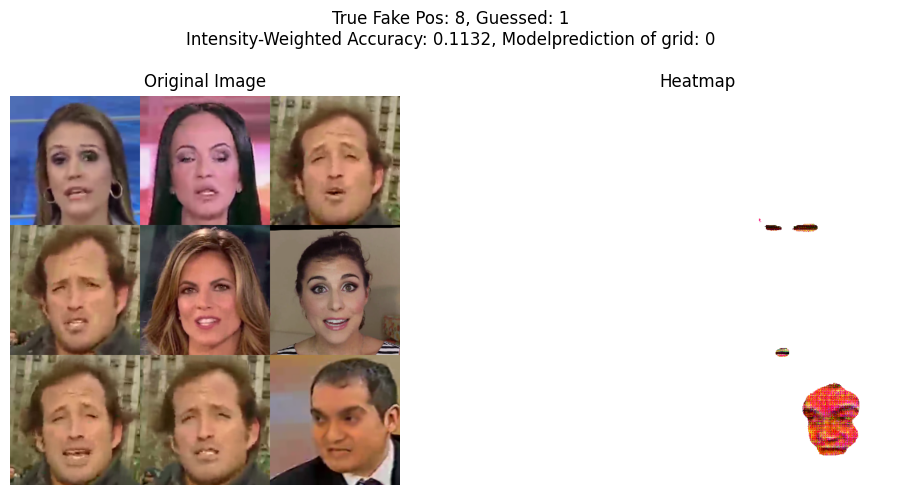

[DEBUG] Visualizing heatmap with shape: (672, 672, 4)


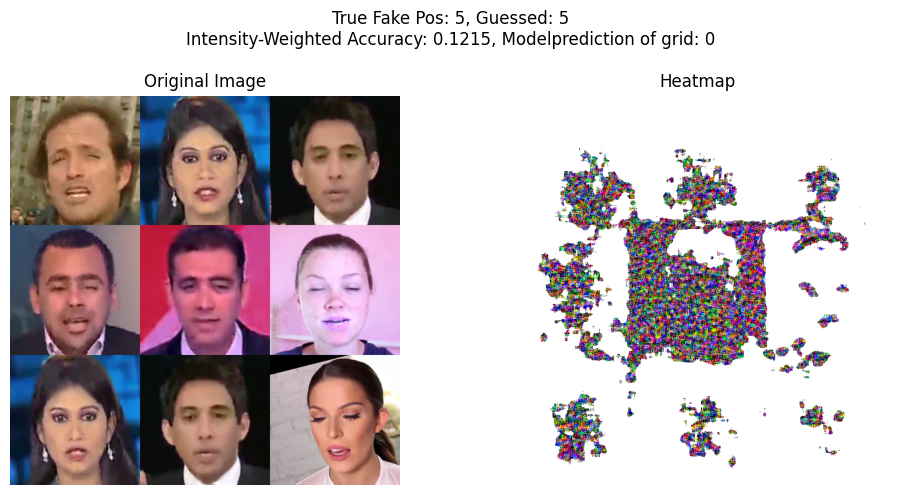

In [74]:
# Let's assume you have loaded results as before:
with open(results_file, "rb") as f:
    results = pickle.load(f)

# Take the first result for demonstration.

for result in results:
    sample = result
    img_np = sample["original_image"]      # Your original image in NumPy format.
    heatmap = sample["heatmap"]              # The generated heatmap.
    true_fake_pos = sample["true_fake_position"]
    guessed_fake_position = sample["guessed_fake_position"]
    model_prediction = sample["model_prediction"]
    intensity_weighted_accuracy = sample.get("accuracy", 0.0)
    grid_split = 3  # or whatever grid_split was used during evaluation.
    
    # Now visualize:
    visualize(img_np, heatmap, true_fake_pos, guessed_fake_position, intensity_weighted_accuracy, grid_split,model_prediction)

In [32]:
def visualize_real_image(img_np):
    """
    Display the original image (in HWC format) without any extra overlays.

    Parameters:
      img_np: A NumPy array representing the image (HWC, e.g., 224x224x3).
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Real Image")
    plt.show()

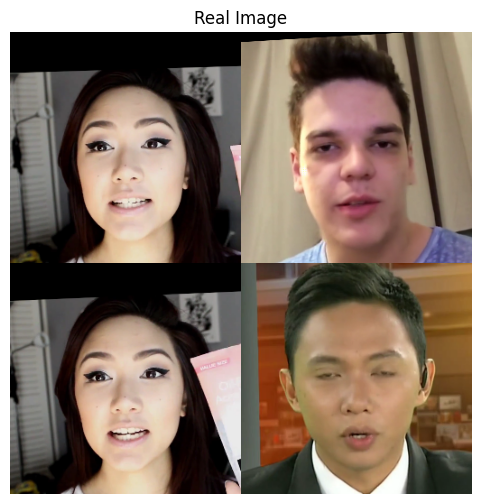

In [59]:
visualize_real_image(img_np)